# Recreating the graphs from the paper and more.
## Experiments
### Apply VIO outlier rejection on the raw data

In [1]:
import os
from Code.UtilityCode.Measurement import Measurement

if not os.path.exists("Data/Measurements_correction"): 
    os.makedirs("Data/Measurements_correction")

for i in range(1, 6):
    sampled_pkl = "Data/Measurements/exp" + str(i) + "_los_sampled.pkl"
    measurement = Measurement()
    measurement.load_sampled_data(sampled_pkl)
    measurement.tb2.vio_frame.outlier_rejection(max_a=0.25)
    measurement.tb3.vio_frame.outlier_rejection(max_a=0.25)
    measurement.tb2.vio_frame.sampled_v = measurement.tb2.vio_frame.v_cor
    measurement.tb3.vio_frame.sampled_v = measurement.tb3.vio_frame.v_cor
    measurement.name = "exp" + str(i) + "_los"
    measurement.save_folder = "Data/Measurements_correction/"
    measurement.save_sampled_data()

### Running the algorihtms
The code bellow runs the analysis. 

The methods have limited parameters accesible in their name. 
For all methods the frequency can be changed. 
For the UPF methods the resample_factor and the sigma_uwb_factor can be changed. By setting multi_particles=0 the UPF is set to a single particle with known initial RP. 
For the Algebraic, QCPQ and NLS method the horizon can be set as well. The horizon reperesent the number of measeruments included in time horizon.
Notice by setting the NLS to a frequency of 1 and an horizon of 10 is equivalent to setting the frequency to 10 with an horizon of 100 and a sampling factor of 10. 

This might take some time to run all methods for all experiments, dependable on your hardware. 
As a reference on a intel CORE vPRO i7 it takes almost 6 hours. Therefor the results are saved in the `results_folder`. 

In [ ]:
import os
import matplotlib.pyplot as plt
from Code.UtilityCode.Measurement import create_experiment, create_experimental_data

data_folder = "Data/Measurements_correction"
results_folder = "Results/experiments"

if not os.path.exists(results_folder): 
    os.makedirs(results_folder)
      
sig_v = 0.08
sig_w = 0.08
sig_uwb = 0.25

experiment_data, measurements = create_experimental_data(data_folder, sig_v, sig_w, sig_uwb)

methods = [
            "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
            "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0",
            "nodriftupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
            "algebraic|frequency=10.0|horizon=100",
            "QCQP|frequency=10.0|horizon=100",
            "NLS|frequency=1.0|horizon=10",
         ]
tas = create_experiment(results_folder, sig_v, sig_w, sig_uwb)
tas.set_ukf_properties(kappa=-1., alpha=1., beta=2., n_azimuth=4, n_altitude=3, n_heading=4)
tas.debug_bool = True
tas.plot_bool = True
tas.run_experiment(methods=methods, redo_bool=False, experiment_data=experiment_data)
plt.show()

### Load and configure the data

In [8]:
from Code.Analysis import TwoAgentAnalysis as TAA
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

result_folders = [
                "Results/experiments", 
                ]

variables = ["error_x_relative", "error_h_relative"]
sigma_dv = [0.08]
sigma_dw = [0.08]
sigma_uwb = [0.25]

taa = TAA.TwoAgentAnalysis(result_folders=result_folders)

upf_exp = {"Method": "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
           "Variables": {
               "Type": ["experiment"],
               "Variable": variables,
               "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
               "Sigma_uwb": sigma_uwb,
               "Frequency": [10.0],
           },
           "Color": "tab:green",
           "Legend": "Ours",
           }
upf_exp_per = {"Method": "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0",
           "Variables": {
               "Type": ["experiment"],
               "Variable": variables,
               "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
               "Sigma_uwb": sigma_uwb,
               "Frequency": [10.0],
           },
           "Color": "tab:orange",
           "Legend": "Ours *",
           }
nodriftupf_exp = {"Method": "nodriftupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
                  "Variables": {
                      "Type": ["experiment"],
                      "Variable": variables,
                      "Sigma_dv": sigma_dv,
                      "Sigma_dw": sigma_dw,
                      "Sigma_uwb": sigma_uwb,
                      "Frequency": [10.0],
                  },
                  "Color": "tab:red",
                  "Legend": r"Ours, $\tilde{\text{w}}$ pseudo-state",
                  }
alg_exp = {"Method": "algebraic|frequency=10.0|horizon=100",
           "Variables": {
               "Type": ["experiment"],
              "Variable": variables,
              "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
              "Sigma_uwb": sigma_uwb,
               "Frequency": [10.0],
           },
           "Color": "tab:brown",
           "Legend": "Algebraic",
           }
qcqp_exp = {"Method": "QCQP|frequency=10.0|horizon=100",
            "Variables": {
                "Type": ["experiment"],
                "Variable": variables,
                "Sigma_dv": sigma_dv,
                "Sigma_dw": sigma_dw,
                "Sigma_uwb": sigma_uwb,
                "Frequency": [10.0],
            },
            "Color": "tab:blue",
            "Legend": "QCQP",
            }
nls_exp = {
            "Method": "NLS|frequency=1.0|horizon=10",
           "Variables": {
               "Type": ["experiment"],
                "Variable": variables,
                "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
                "Sigma_uwb": sigma_uwb,
               "Frequency": [1.0],
           },
           "Color": "tab:purple",
           "Legend": "NLS *",
           }


methods_order = [ upf_exp, 

                  nodriftupf_exp,
                  # alg_exp,
                  qcqp_exp,
                  upf_exp_per,
                  nls_exp, 
                ]

df, methods_names, methods_colors, methods_legends = taa.filter_methods_new(methods_order)

Loading 3 %: Results/experiments/exp_NLS|frequency=1c0|horizon=10|exp1_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 6 %: Results/experiments/exp_NLS|frequency=1c0|horizon=10|exp2_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 10 %: Results/experiments/exp_algebraic|frequency=10c0|horizon=100|exp4_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 13 %: Results/experiments/exp_QCQP|frequency=10c0|horizon=100|exp3_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 16 %: Results/experiments/exp_nodriftupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|exp1_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 20 %: Results/experiments/exp_nodriftupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|exp5_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 23 %: Results/experiments/exp_losupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|multi_particles=0|exp4_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 26 %: Results/experime

### Plotting the boxplots and statistical results
Make sure to have run 

-----------------------------------------
Statistacal Analysis
-----------------------------------------
error_x_relative
losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|Type_['experiment']|Variable_['error_x_relative', 'error_h_relative']|Sigma_dv_[0.08]|Sigma_dw_[0.08]|Sigma_uwb_[0.25]|Frequency_[10.0]
2.3177645547900982  pm  1.563603415812723 ; median:  1.9472889826053592
losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0|Type_['experiment']|Variable_['error_x_relative', 'error_h_relative']|Sigma_dv_[0.08]|Sigma_dw_[0.08]|Sigma_uwb_[0.25]|Frequency_[10.0]
1.3678704825801187  pm  1.075323612240774 ; median:  1.2027257323612912
nodriftupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|Type_['experiment']|Variable_['error_x_relative', 'error_h_relative']|Sigma_dv_[0.08]|Sigma_dw_[0.08]|Sigma_uwb_[0.25]|Frequency_[10.0]
2.4462299106023817  pm  1.5816121713442701 ; median:  2.041462866322549
algebraic|frequency=10.0|horizon=100|Type_[

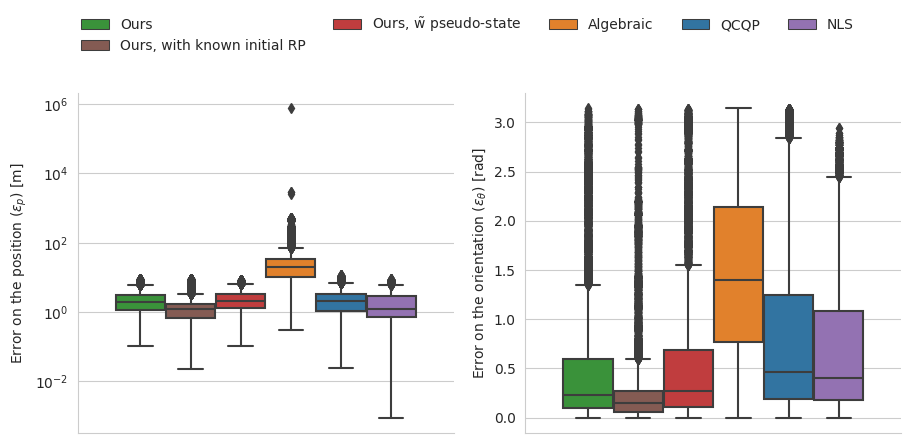

In [9]:
import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

taa.print_statistics(methods_names, ["error_x_relative", "error_h_relative"], df)
g = taa.boxplot_exp(df, methods_color=methods_colors, methods_legend=methods_legends,
                hue_variable="Name", hue_order=methods_names,
                col_variable="Variable",
                row_variable=None,
                x_variable="Sigma_dv",
                )

g.axes_dict["error_x_relative"].set_yscale("log")
g.axes_dict["error_h_relative"].set_ylabel(taa.y_label["error_h_relative"])
g.axes_dict["error_x_relative"].set_ylabel(taa.y_label["error_x_relative"])
sns.move_legend(g, loc="upper center", bbox_to_anchor= (0.5, 0.98), ncol=5)
plt.subplots_adjust(top=0.8, bottom=0.12, left=0.06, right=0.99)
# plt.suptitle("Experiments")
plt.show()

### Time line plots

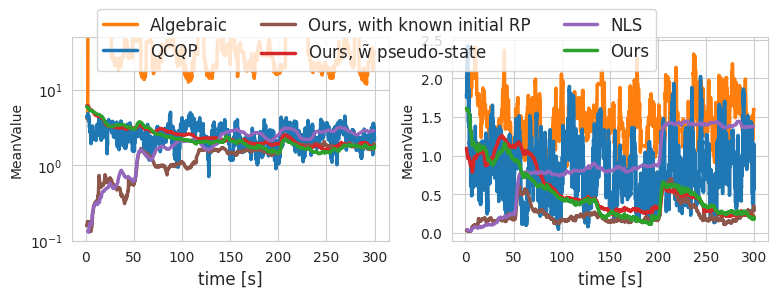

In [10]:
#reshuffle the order so the lines are visible.
methods_names = [
                "algebraic|frequency=10.0|horizon=100|Type_['experiment']|Variable_['error_x_relative', 'error_h_relative']|Sigma_dv_[0.08]|Sigma_dw_[0.08]|Sigma_uwb_[0.25]|Frequency_[10.0]", 
                 "QCQP|frequency=10.0|horizon=100|Type_['experiment']|Variable_['error_x_relative', 'error_h_relative']|Sigma_dv_[0.08]|Sigma_dw_[0.08]|Sigma_uwb_[0.25]|Frequency_[10.0]",
                 "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0|Type_['experiment']|Variable_['error_x_relative', 'error_h_relative']|Sigma_dv_[0.08]|Sigma_dw_[0.08]|Sigma_uwb_[0.25]|Frequency_[10.0]", 
                 "nodriftupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|Type_['experiment']|Variable_['error_x_relative', 'error_h_relative']|Sigma_dv_[0.08]|Sigma_dw_[0.08]|Sigma_uwb_[0.25]|Frequency_[10.0]", 
                 "NLS|frequency=1.0|horizon=10|Type_['experiment']|Variable_['error_x_relative', 'error_h_relative']|Sigma_dv_[0.08]|Sigma_dw_[0.08]|Sigma_uwb_[0.25]|Frequency_[1.0]",
                "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|Type_['experiment']|Variable_['error_x_relative', 'error_h_relative']|Sigma_dv_[0.08]|Sigma_dw_[0.08]|Sigma_uwb_[0.25]|Frequency_[10.0]",
            ]
        
g = taa.lineplot(df, methods_names, methods_colors,
                         methods_legends=methods_legends)

g.axes_dict["error_h_relative"].set_ylabel(taa.y_label["error_h_relative"])
g.axes_dict["error_x_relative"].set_ylabel(taa.y_label["error_x_relative"])
plt.show()

## Sim2Real

In [1]:
import os
from Code.UtilityCode.Measurement import create_experiment, create_experimental_sim_data

data_folder = "Data/Measurements_correction"
results_folder = "Results/sim2real"

if not os.path.exists(results_folder): 
    os.makedirs(results_folder)

sig_v = 0.08
sig_w = 0.08
sig_uwb = 0.25

experiment_data, measurements = create_experimental_sim_data(data_folder, sig_v, sig_w, sig_uwb)
methods = [
            "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
            "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0",
            "nodriftupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
            "algebraic|frequency=10.0|horizon=100",
            "QCQP|frequency=10.0|horizon=100",
            "NLS|frequency=1.0|horizon=10",
           ]

tas = create_experiment(results_folder, sig_v, sig_w, sig_uwb)
tas.debug_bool = True
tas.plot_bool = False
tas.run_experiment(methods=methods, redo_bool=False, experiment_data=experiment_data, res_type="simulation", prefix="sim_")

['exp3_los_sampled.pkl', 'exp4_los_sampled.pkl', 'exp1_los_sampled.pkl', 'exp2_los_sampled.pkl', 'exp5_los_sampled.pkl']
2024-09-24 09:22:09.011307   losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0 of  ['losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0', 'losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0', 'nodriftupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0', 'algebraic|frequency=10.0|horizon=100', 'QCQP|frequency=10.0|horizon=100', 'NLS|frequency=1.0|horizon=10']
Result file exists: Results/sim2real/sim_losupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|exp3_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
2024-09-24 09:22:10.956548   losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0 of  ['losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0', 'losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0', 'nodriftupf|frequency=10.0|resampl

### Boxplots for comparison with experiments.

In [11]:
from Code.Analysis import TwoAgentAnalysis as TAA
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import seaborn as sns

result_folders = [
                "Results/experiments",
                "Results/sim2real", 
                ]

variables = ["error_x_relative", "error_h_relative"]
sigma_dv = [0.08]
sigma_dw = [0.08]
sigma_uwb = [0.25]

taa_sim = TAA.TwoAgentAnalysis(result_folders=result_folders)


upf_sim = {"Method": "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
           "Variables": {
               "Type": ["simulation"],
               "Variable": variables,
               "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
               "Sigma_uwb": sigma_uwb,
               "Frequency": [10.0],
           },
           "Color": "lightgreen",
           "Legend": "Ours (sim)",
           }
upf_sim_per = {"Method": "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0",
           "Variables": {
               "Type": ["simulation"],
               "Variable": variables,
               "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
               "Sigma_uwb": sigma_uwb,
               "Frequency": [10.0],
           },
           "Color": "bisque",
           "Legend": "Ours * (sim)",
           }
nodriftupf_sim = {"Method": "nodriftupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
                  "Variables": {
                      "Type": ["simulation"],
                      "Variable": variables,
                      "Sigma_dv": sigma_dv,
                      "Sigma_dw": sigma_dw,
                      "Sigma_uwb": sigma_uwb,
                      "Frequency": [10.0],
                  },
                  "Color": "salmon",
                  "Legend": r"Ours, $\tilde{\text{w}}$ pseudo-state (sim)",
                  }
alg_sim = {"Method": "algebraic|frequency=10.0|horizon=100",
           "Variables": {
               "Type": ["simulation"],
              "Variable": variables,
              "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
              "Sigma_uwb": sigma_uwb,
               "Frequency": [10.0],
           },
           "Color": "chocolate",
           "Legend": "Algebraic (sim)",
           }
qcqp_sim = {"Method": "QCQP|frequency=10.0|horizon=100",
            "Variables": {
                "Type": ["simulation"],
                "Variable": variables,
                "Sigma_dv": sigma_dv,
                "Sigma_dw": sigma_dw,
                "Sigma_uwb": sigma_uwb,
                "Frequency": [10.0],
            },
            "Color": "cornflowerblue",
            "Legend": "QCQP (sim)",
            }
nls_sim = {
            "Method": "NLS|frequency=1.0|horizon=10",
           "Variables": {
               "Type": ["simulation"],
                "Variable": variables,
                "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
                "Sigma_uwb": sigma_uwb,
               "Frequency": [1.0],
           },
           "Color": "thistle",
           "Legend": "NLS (sim)",
           }


methods_order_sim = [ upf_exp, upf_sim, 
                  upf_exp_per, upf_sim_per,
                  nodriftupf_exp, nodriftupf_sim,
                  alg_exp, alg_sim,
                  qcqp_exp, qcqp_sim,
                  nls_exp, nls_sim
                ]

df_sim, methods_names_sim, methods_colors_sim, methods_legends_sim = taa_sim.filter_methods_new(methods_order_sim)

Loading 3 %: Results/experiments/exp_NLS|frequency=1c0|horizon=10|exp1_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 6 %: Results/experiments/exp_NLS|frequency=1c0|horizon=10|exp2_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 10 %: Results/experiments/exp_algebraic|frequency=10c0|horizon=100|exp4_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 13 %: Results/experiments/exp_QCQP|frequency=10c0|horizon=100|exp3_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 16 %: Results/experiments/exp_nodriftupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|exp1_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 20 %: Results/experiments/exp_nodriftupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|exp5_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 23 %: Results/experiments/exp_losupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|multi_particles=0|exp4_los_sampled|s_uwb=0c25|s_dv=0c08|s_dw=0c08.pkl
Loading 26 %: Results/experime

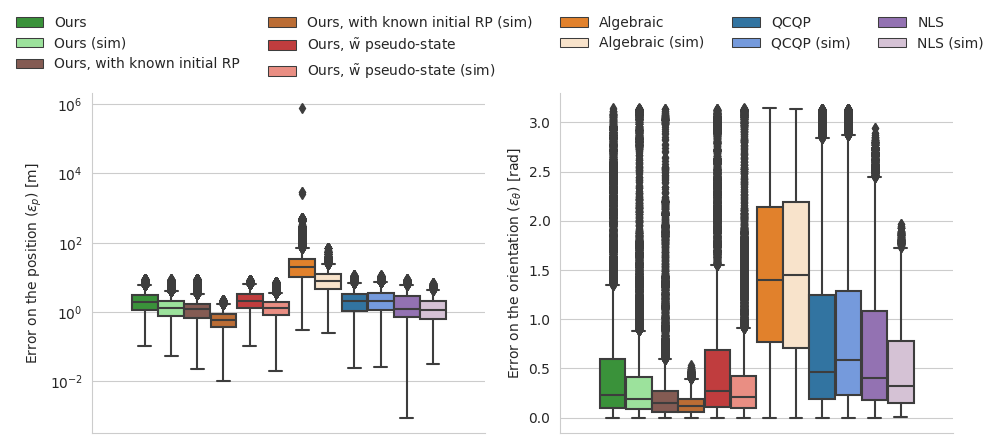

In [13]:
import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

g = taa_sim.boxplot_exp(df_sim, methods_color=methods_colors_sim, methods_legend=methods_legends_sim,
                hue_variable="Name", hue_order=methods_names_sim,
                col_variable="Variable",
                row_variable=None,
                x_variable="Sigma_dv",
                )

g.axes_dict["error_x_relative"].set_yscale("log")
g.axes_dict["error_h_relative"].set_ylabel(taa_sim.y_label["error_h_relative"])
g.axes_dict["error_x_relative"].set_ylabel(taa_sim.y_label["error_x_relative"])
sns.move_legend(g, loc="upper center", bbox_to_anchor= (0.5, 0.98), ncol=5)
plt.subplots_adjust(top=0.8, bottom=0.12, left=0.06, right=0.99)
# plt.suptitle("Experiments")
plt.show()

## Simulations
It can take quite a long time to run all simulations. (Up to 4 days on a server that ran 25 simulations in parallel).
The results of the simulation can be shared by sending a mail to the author. (yuri.durodie@vub.be).

This one is setup to only run "sim_0" for the sake of the example. 
By removing the sim_list parameter all simulations will be run. (Will take very long).  

In [ ]:
import os 
os.environ["OPENBLAS_NUM_THREADS"]= "2"
import Code.Simulation.MultiRobotClass as MRC


result_folder = "./Results/simulations"
trajectory_folder = "./Data/Simulations"

if not os.path.exists(result_folder): 
    os.makedirs(result_folder)

alpha = 1
kappa = -1.
beta = 2.
n_azimuth = 4
n_altitude = 3
n_heading = 4

methods = [  
            "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
            "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0",
            "nodriftupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
            "algebraic|frequency=10.0|horizon=100",
            "QCQP|frequency=10.0|horizon=100",
            "NLS|frequency=1.0|horizon=10",
               ]

dvs = [0.1, 0.01]
sigma_dw_factor =  1.0
d_uwbs = [1.0, 0.1]
for dv in dvs:
    sigma_dv = dv 
    sigma_dw = sigma_dw_factor * dv 
    for duwb in d_uwbs:
        sigma_uwb = duwb 
        TAS = MRC.TwoAgentSystem(trajectory_folder=trajectory_folder, result_folder=result_folder)
        TAS.debug_bool = True
        TAS.plot_bool = False
        TAS.set_uncertainties(sigma_dv, sigma_dw, sigma_uwb)
        TAS.set_ukf_properties(alpha = alpha, beta =  beta, kappa = kappa,
                               n_azimuth = n_azimuth, n_altitude=n_altitude, n_heading=n_heading)
        TAS.run_simulations(methods=methods, redo_bool=False, sim_list=["sim_0"])

### Load and configure the data


In [4]:
from Code.Analysis import TwoAgentAnalysis as TAA
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

result_folders = [
                "Results/simulations", 
                ]

variables = ["error_x_relative", "error_h_relative"]
sigma_dv = [0.1, 0.01]
sigma_dw =  [0.1, 0.01]
sigma_uwb =  [1., 0.1]

taa_sim_ful = TAA.TwoAgentAnalysis(result_folders=result_folders)

upf_sim_full = {"Method": "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
           "Variables": {
               "Type": ["simulation"],
               "Variable": variables,
               "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
               "Sigma_uwb": sigma_uwb,
               "Frequency": [10.0],
           },
           "Color": "tab:green",
           "Legend": "Ours",
           }
upf_sim_full_per = {"Method": "losupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0|multi_particles=0",
           "Variables": {
               "Type": ["simulation"],
               "Variable": variables,
               "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
               "Sigma_uwb": sigma_uwb,
               "Frequency": [10.0],
           },
           "Color": "tab:brown",
           "Legend": "Ours, with known initial RP",
           }
nodriftupf_sim_full = {"Method": "nodriftupf|frequency=10.0|resample_factor=0.1|sigma_uwb_factor=1.0",
                  "Variables": {
                      "Type": ["simulation"],
                      "Variable": variables,
                      "Sigma_dv": sigma_dv,
                      "Sigma_dw": sigma_dw,
                      "Sigma_uwb": sigma_uwb,
                      "Frequency": [10.0],
                  },
                  "Color": "tab:red",
                  "Legend": r"Ours, $\tilde{\text{w}}$ pseudo-state",
                  }
alg_sim_full = {"Method": "algebraic|frequency=10.0|horizon=100",
           "Variables": {
               "Type": ["simulation"],
              "Variable": variables,
              "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
              "Sigma_uwb": sigma_uwb,
               "Frequency": [10.0],
           },
           "Color": "tab:orange",
           "Legend": "Algebraic",
           }
qcqp_sim_full = {"Method": "QCQP|frequency=10.0|horizon=100",
            "Variables": {
                "Type": ["simulation"],
                "Variable": variables,
                "Sigma_dv": sigma_dv,
                "Sigma_dw": sigma_dw,
                "Sigma_uwb": sigma_uwb,
                "Frequency": [10.0],
            },
            "Color": "tab:blue",
            "Legend": "QCQP",
            }
nls_sim_full = {
            "Method": "NLS|frequency=1.0|horizon=10",
           "Variables": {
               "Type": ["simulation"],
                "Variable": variables,
                "Sigma_dv": sigma_dv,
               "Sigma_dw": sigma_dw,
                "Sigma_uwb": sigma_uwb,
               "Frequency": [1.0],
           },
           "Color": "tab:purple",
           "Legend": "NLS",
           }


methods_order_sim_full = [ upf_sim_full, 
                  upf_sim_full_per,
                  nodriftupf_sim_full,
                  alg_sim_full,
                  qcqp_sim_full, 
                  nls_sim_full, 
                ]

df_sim_full, methods_names_sim_full, methods_colors_sim_full, methods_legends_sim_full = taa_sim_ful.filter_methods_new(methods_order_sim_full)

Loading 0 %: Results/simulations/sim_nodriftupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|sim_21|s_uwb=0c1|s_dv=0c1|s_dw=0c1.pkl
Loading 0 %: Results/simulations/sim_QCQP|frequency=10c0|horizon=100|sim_12|s_uwb=1c0|s_dv=0c01|s_dw=0c01.pkl
Loading 0 %: Results/simulations/sim_NLS|frequency=1c0|horizon=10|sim_0|s_uwb=0c1|s_dv=0c01|s_dw=0c01.pkl
Loading 0 %: Results/simulations/sim_losupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|sim_47|s_uwb=1c0|s_dv=0c1|s_dw=0c1.pkl
Loading 0 %: Results/simulations/sim_nodriftupf|frequency=10c0|resample_factor=0c1|sigma_uwb_factor=1c0|sim_36|s_uwb=1c0|s_dv=0c01|s_dw=0c01.pkl
Loading 0 %: Results/simulations/sim_QCQP|frequency=10c0|horizon=100|sim_6|s_uwb=1c0|s_dv=0c1|s_dw=0c1.pkl
Loading 0 %: Results/simulations/sim_algebraic|frequency=10c0|horizon=100|sim_41|s_uwb=1c0|s_dv=0c01|s_dw=0c01.pkl
Loading 0 %: Results/simulations/sim_NLS|frequency=1c0|horizon=10|sim_34|s_uwb=0c1|s_dv=0c01|s_dw=0c01.pkl
Loading 0 %: Results/simulat

### Boxplots

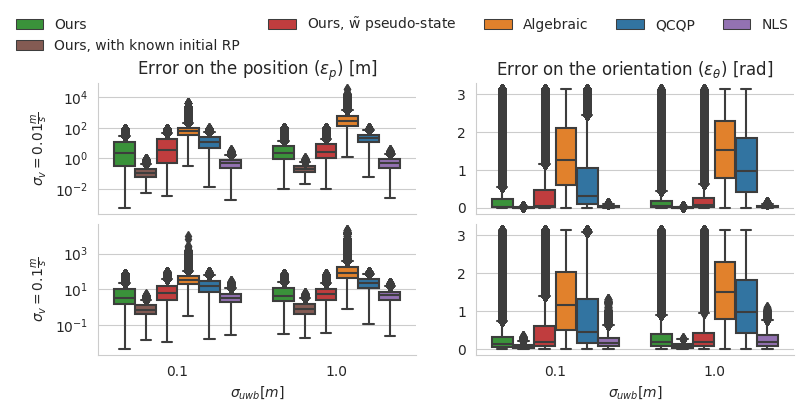

In [5]:
g = taa_sim_ful.boxplot_exp(df_sim_full, methods_color=methods_colors_sim_full, methods_legend=methods_legends_sim_full,
                        hue_variable="Name", hue_order=methods_names_sim_full,
                        col_variable="Variable", col_order = ["error_x_relative", "error_h_relative"],
                        row_variable="Sigma_dv", row_order = [0.01, 0.1],
                        x_variable="Sigma_uwb", x_order=[0.1, 1.],
                        )
g.fig.set_size_inches(8, 4)
for ax in g.axes_dict:
    if "error_x_relative" in ax:
        g.axes_dict[ax].set_yscale("log")
        if 0.1 in ax:
            g.axes_dict[ax].set_ylabel(r"$\sigma_v = 0.1 \frac{m}{s}$")
        if 0.01 in ax:
            g.axes_dict[ax].set_ylabel(r"$\sigma_v = 0.01 \frac{m}{s}$")
    if 0.1 in ax:
        g.axes_dict[ax].set_xlabel(r"$\sigma_{uwb} [m]$")
    if 0.01 in ax:
        if "error_h_relative" in ax:
            g.axes_dict[ax].set_title(taa_sim_ful.y_label["error_h_relative"])
        if  "error_x_relative" in ax:
            g.axes_dict[ax].set_title(taa_sim_ful.y_label["error_x_relative"])
# plt.figure(0).set_size_inches(10, 10)
sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.5, 1.), ncol=5)
plt.subplots_adjust(top=0.8, bottom=0.12, left=0.12, right=0.99)
# plt.suptitle("Monte Carlo simulation")
plt.show()

## Inspecting the Data
### Experiments 
#### VIO Outlier rejection

----- Data/Measurements/exp1_los_sampled.pkl -----
Mean v error:  [ 0.0155058  -0.00245624  0.00244192]  Std v error:  [0.07778434 0.05360545 0.05043485]
Mean v_cor error:  [ 0.02361337 -0.0027429   0.00259792]  Std v_cor error:  [0.07269457 0.01909133 0.01527098]
Mean w error:  [ 0.00343401 -0.00092385 -0.01021397]  Std w error:  [0.02361297 0.06921546 0.09700146]
Mean v error:  [ 0.02454076 -0.00963534 -0.00133624]  Std v error:  [0.08642549 0.03224549 0.02800435]
Mean v_cor error:  [ 0.02214852 -0.01322837 -0.00037058]  Std v_cor error:  [0.06802973 0.03311511 0.01780942]
Mean w error:  [ 0.00069506 -0.00018057 -0.00055274]  Std w error:  [0.02567372 0.08057573 0.06766249]
----- Data/Measurements/exp2_los_sampled.pkl -----
Mean v error:  [ 0.01070282 -0.00068898  0.00145856]  Std v error:  [0.07656747 0.05132167 0.0493492 ]
Mean v_cor error:  [ 0.03140098 -0.0013763   0.01017532]  Std v_cor error:  [0.10443563 0.02131212 0.04038503]
Mean w error:  [ 0.00066778 -0.00187309 -0.0082639

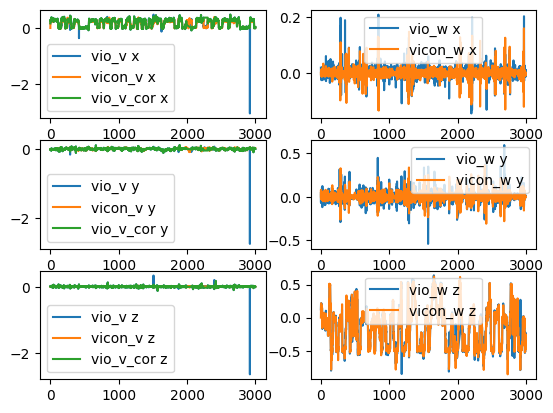

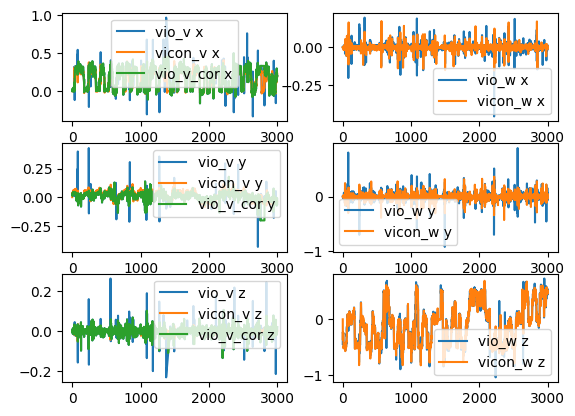

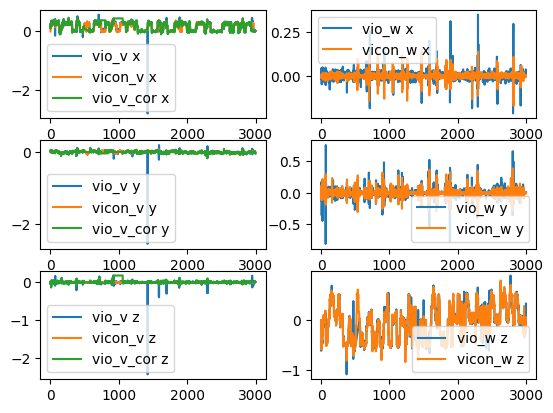

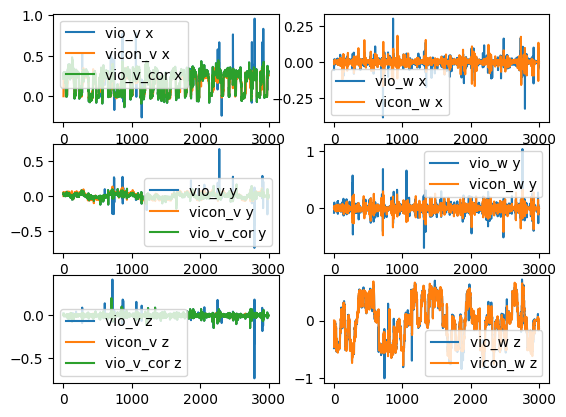

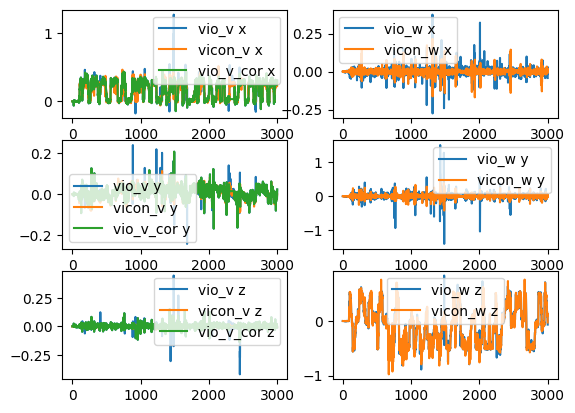

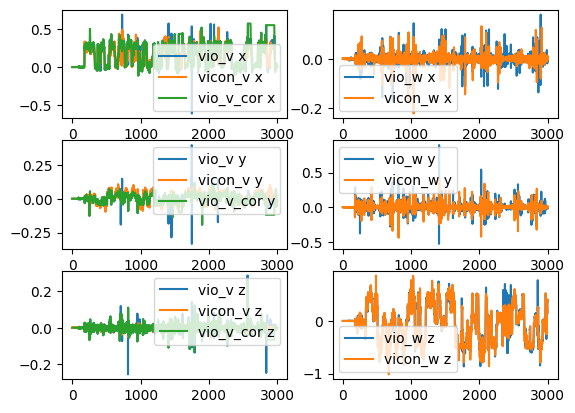

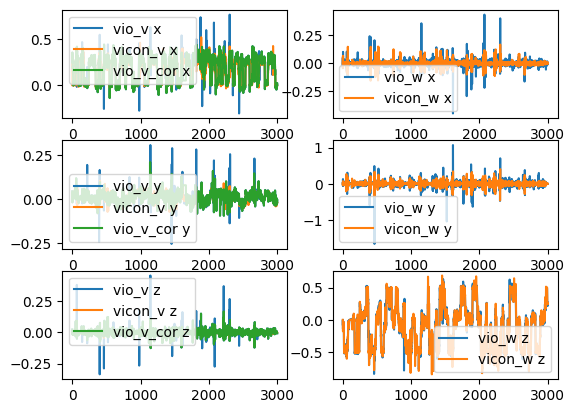

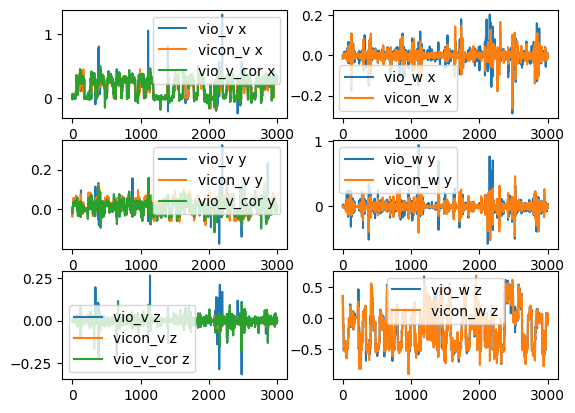

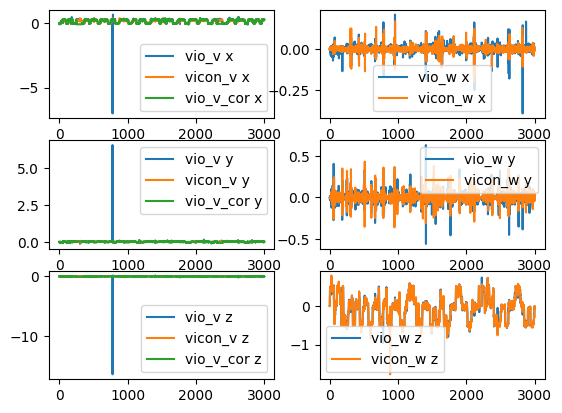

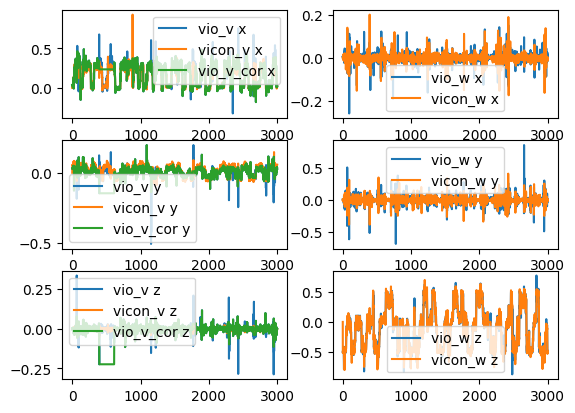

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from Code.UtilityCode.Measurement import Measurement

for i in range(1, 6):
    sampled_pkl = "Data/Measurements/exp" + str(i) + "_los_sampled.pkl"
    measurement = Measurement()
    measurement.load_sampled_data(sampled_pkl)
    measurement.tb2.vio_frame.outlier_rejection(max_a=2.)
    measurement.tb3.vio_frame.outlier_rejection(max_a=2.)
    print("----- " + sampled_pkl + " -----")
    measurement.get_VIO_error(plot=True)
plt.show()
    

#### UWB Data

mean error:  0.11147075284328105 std error:  0.0805454525030446
mean error:  0.11287333238623701 std error:  0.09357942082567895
mean error:  0.1303746893327531 std error:  0.1569713131131121
mean error:  0.12624237173858383 std error:  0.14517660501128019
mean error:  0.10848886077671259 std error:  0.13306711744950567


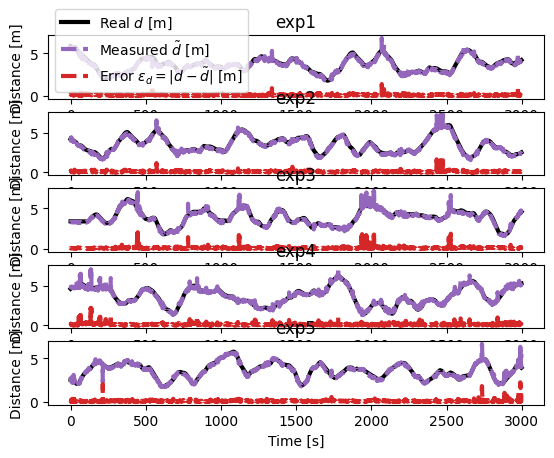

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from Code.UtilityCode.Measurement import Measurement
fig, ax = plt.subplots(5, 1)
for i in range(1, 6):
    sampled_pkl = "Data/Measurements/exp" + str(i) + "_los_sampled.pkl"
    measurement = Measurement()
    measurement.load_sampled_data(sampled_pkl)
    measurement.get_uwb_distances()
    measurement.uwb.plot_real(ax=ax[i-1])
    ax[i-1].set_title("exp"+str(i))
    ax[i-1].set_ylabel("Distance [m]")
ax[-1].set_xlabel("Time [s]")
ax[0].legend()